In [1]:
import glob
import json
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

sns.set(style="whitegrid", palette="muted")

from concurrent.futures import ProcessPoolExecutor, as_completed

from tqdm import tqdm

In [2]:
!mkdir -p plots

In [3]:
results_dir = "results/1648838189"
result_name = "5000-ce"

In [4]:
forecast_files = glob.glob(f"{results_dir}/forecast.*.jsonl")

key_to_timestamps = defaultdict(list)
key_to_last_seqnos = defaultdict(list)
key_to_last_seqno_to_forecast = defaultdict(dict)
for path in tqdm(forecast_files):
    with open(path) as f:
        for line in f:
            loaded = json.loads(line)
            key_id = str(loaded["key_id"])
            key_to_timestamps[key_id].append(loaded["processing_time"])
            key_to_last_seqnos[key_id].append(loaded["last_seqno"])
            key_to_last_seqno_to_forecast[key_id][loaded["last_seqno"]] = loaded[
                "forecast"
            ]

100%|███████████████████████████████████████████| 16/16 [03:03<00:00, 11.46s/it]


In [5]:
source_files = glob.glob(f"{results_dir}/source.*.jsonl")
key_to_source_series = defaultdict(list)
key_to_source_timestamps = defaultdict(list)
key_to_source_seqno = defaultdict(list)
for path in source_files:
    with open(path) as f:
        for line in tqdm(f):
            loaded = json.loads(line)
            for entry in loaded:
                key_id = str(entry["key_id"])
                key_to_source_series[key_id].append(entry["value"])
                key_to_source_timestamps[key_id].append(entry["ingest_time"])
                key_to_source_seqno[key_id].append(entry["seq_no"])

8639it [01:36, 89.52it/s] 


In [6]:
num_forecasts = pd.DataFrame(
    [{"key": k, "num_forecasts": len(v)} for k, v in key_to_last_seqnos.items()]
)
num_forecasts.describe()

,num_forecasts
count,5000.000000
mean,10.832800
std,7.824697
min,1.000000
25%,5.000000
50%,9.000000
75%,16.000000
max,27.000000


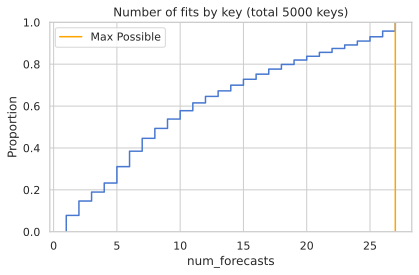

In [7]:
sns.ecdfplot(num_forecasts["num_forecasts"])
plt.title(f"Number of fits by key (total {len(num_forecasts)} keys)")
plt.axvline(27, color="orange", label="Max Possible")
plt.legend()
plt.tight_layout()
plt.savefig(f"plots/{result_name}-nfits.pdf", dpi=300)

In [8]:
num_forecasts.to_csv(f"plots/{result_name}-nfits.csv", index=None)

In [23]:
def compute_key(key):
    pred_df = (
        pd.DataFrame(
            {
                "timestamp": key_to_timestamps[key],
                "last_seqno": key_to_last_seqnos[key],
            }
        )
        .sort_values("timestamp")
        .set_index("timestamp")
    )
    true_df = (
        pd.DataFrame(
            {
                "timestamp": key_to_source_timestamps[key],
                "avg_cpu": key_to_source_series[key],
                "seq_no": key_to_source_seqno[key],
            }
        )
        .sort_values("timestamp")
        .set_index("timestamp")
    )

    merged = pd.merge_asof(
        left=true_df, right=pred_df, on="timestamp", direction="backward"
    )

    forecast = key_to_last_seqno_to_forecast[key]
    frame = pd.DataFrame(forecast)
    frame = (
        frame.T.reset_index()
        .melt("index")
        .rename(columns={"variable": "seq_delta", "index": "last_seqno"})
    )

    m = merged.dropna().reset_index(drop=True)
    m.loc[:, "seq_delta"] = (m["seq_no"] - m["last_seqno"]).astype(int)
    final = m.merge(frame, how="left", on=["last_seqno", "seq_delta"])

    mse_per_key_per_s = final.groupby(final["timestamp"].astype(int)).apply(
        lambda d: pd.Series(
            {"mse": ((d["avg_cpu"] - d["value"]) ** 2).mean(), "count": len(d)}
        )
    )
    mse_per_key_per_s["key"] = key
    return mse_per_key_per_s


with ProcessPoolExecutor() as executor:
    futs = executor.map(compute_key, key_to_timestamps.keys())
    mses = list(futs)

In [65]:
# we are dropping some keys here :sigh:
# need to figure out how to handle a key that's never fitted
# final length 4965 for 5000
all_mse = pd.concat([f.reset_index() for f in mses if len(f)])

In [70]:
all_mse.to_parquet(f"plots/{result_name}-all_mse.pq", index=None)

In [72]:
mse_by_timestamp = all_mse.groupby("timestamp").apply(
    lambda d: (d["mse"] * d["count"]).sum() / (d["count"].sum())
)

In [77]:
mse_by_timestamp.index = mse_by_timestamp.index - mse_by_timestamp.index.min()

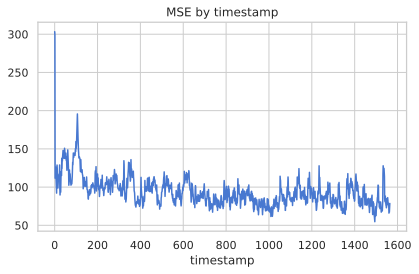

In [81]:
mse_by_timestamp.plot()
plt.title("MSE by timestamp")
plt.tight_layout()
plt.savefig(f"plots/{result_name}-mse-time.pdf", dpi=300)
mse_by_timestamp.to_csv(f"plots/{result_name}-mse-time.csv", index=True)

In [3]:
from glob import glob

In [14]:
m = {
    # "100-rr": 1648827940,
    # "100-ce": 1648828073,
    # "1000-rr": 1648829259,
    # "1000-ce": 1648829770,
    # "5000-rr": 1648835886,
    # "5000-ce": 1648838189,
}

In [113]:
computed_mses

['plots/10000-ce-32-mse-time.csv', 'plots/10000-rr-32-mse-time.csv']

In [ ]:
computed_mses = [f for f in glob("plots/*-mse-time.csv") if "10000" in f]
chunk = []
for path in computed_mses:
    df = pd.read_csv(path)
    expr = path.split("/")[1].split("-mse")[0]
    df["expr"] = expr
    # df["num_keys"] = int(expr.split("-")[0])
    df["policy"] = {"ce": "Regret Optimized", "rr": "Round Robin"}[expr.split("-")[1]]

    # with open(f"results/{m[expr]}/config.json") as f:
    # df["trial"] = f"{expr}-{json.load(f)['workers']}-workers"
    chunk.append(df)

In [115]:
!ls -lh plots/10000-ce-32-mse-time.csv

-rw-rw-r-- 1 ubuntu ubuntu 93K Apr 15 22:23 plots/10000-ce-32-mse-time.csv


In [151]:
computed_mses = [f for f in glob("plots/*-mse-time.csv") if "10000" in f]
chunk = []
for path in computed_mses:
    df = pd.read_csv(path)
    expr = path.split("/")[1].split("-mse")[0]
    df["expr"] = expr
    # df["num_keys"] = int(expr.split("-")[0])
    df["policy"] = {"ce": "Regret Optimized", "rr": "Round Robin"}[expr.split("-")[1]]

    # with open(f"results/{m[expr]}/config.json") as f:
    # df["trial"] = f"{expr}-{json.load(f)['workers']}-workers"
    chunk.append(df)

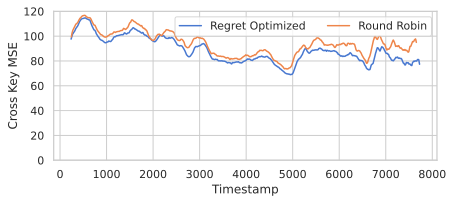

In [160]:
df_ = pd.concat(chunk).reset_index(drop=True)
df_ = df_.rename(columns={"0": "mse"})
df_ = df_.sort_values("policy", ascending=False).sort_values("timestamp")
df_ = df_.groupby("policy").rolling(150).mean().dropna().reset_index()

plt.figure(figsize=(6.5, 3))

sns.lineplot(
    data=df_,
    x="timestamp",
    y="mse",
    hue="policy",
)
plt.xlabel("Timestamp")
plt.ylim(0, 120)
plt.ylabel("Cross Key MSE")
plt.legend(loc="upper right", ncol=2)
plt.tight_layout()
plt.savefig("april-15-comparison.pdf", dpi=300)

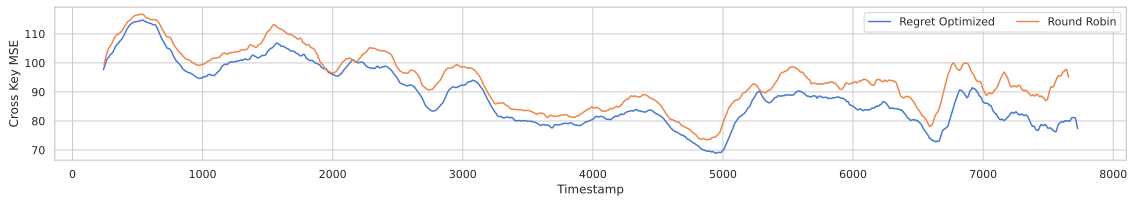

In [261]:
df_ = pd.concat(chunk).reset_index(drop=True)
df_ = df_.rename(columns={"0": "mse"})
df_ = df_.sort_values("policy", ascending=False).sort_values("timestamp")
df_ = df_.groupby("policy").rolling(150).mean().dropna().reset_index()

plt.figure(figsize=(16, 3))

sns.lineplot(
    data=df_,
    x="timestamp",
    y="mse",
    hue="policy",
)
plt.xlabel("Timestamp")
# plt.ylim(0, 120)
plt.ylabel("Cross Key MSE")
plt.legend(loc="upper right", ncol=2)
plt.tight_layout()
plt.savefig("april-15-comparison-wide.pdf", dpi=300)

In [159]:
df_ = pd.concat(chunk).reset_index(drop=True)
df_ = df_.rename(columns={"0": "mse"})
df_ = df_.sort_values("policy", ascending=False).sort_values("timestamp")
df_ = df_.groupby("policy").rolling(150).mean().dropna().reset_index()

ce_mse = df_[df_["policy"] == "Regret Optimized"].set_index("timestamp")["mse"]
rr_mse = df_[df_["policy"] == "Round Robin"].set_index("timestamp")["mse"]

((ce_mse - rr_mse) / rr_mse).dropna()

timestamp
1342.733333   -0.035338
2711.520000   -0.064218
2716.453333   -0.065871
3653.893333   -0.032542
3678.940000   -0.050473
4101.140000   -0.033481
5336.106667   -0.036728
6032.846667   -0.100474
6359.993333   -0.060271
6804.580000   -0.089024
6817.446667   -0.069924
6945.333333   -0.037984
7159.346667   -0.171274
7225.366667   -0.097141
7365.880000   -0.107414
7521.500000   -0.157269
Name: mse, dtype: float64

In [158]:
df_

,timestamp,mse,expr,policy
0,0,54.484296,10000-ce-32,Regret Optimized
4121,0,33.753144,10000-rr-32,Round Robin
4122,1,19.626122,10000-rr-32,Round Robin
1,1,102.156444,10000-ce-32,Regret Optimized
4123,7,33.756574,10000-rr-32,Round Robin
...,...,...,...,...
4116,7797,73.940507,10000-ce-32,Regret Optimized
4117,7798,84.385836,10000-ce-32,Regret Optimized
4118,7799,75.381995,10000-ce-32,Regret Optimized
4119,7800,72.112609,10000-ce-32,Regret Optimized


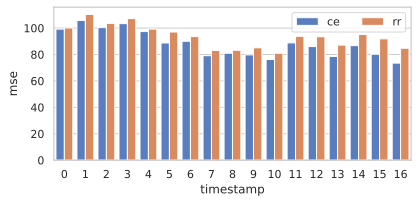

In [110]:
df_ = pd.concat(chunk).reset_index(drop=True)
df_ = df_.rename(columns={"0": "mse"})
df_ = df_.sort_values("policy", ascending=False).sort_values("timestamp")
df_ = df_.groupby(["policy", df_["timestamp"] // 480])["mse"].mean().reset_index()

plt.figure(figsize=(6, 3))

sns.barplot(
    data=df_,
    x="timestamp",
    y="mse",
    hue="policy",
)
plt.legend(loc="upper right", ncol=2)
plt.tight_layout()
plt.savefig("april-15-comparison.pdf", dpi=300)

In [246]:
rr_num_fits = pd.read_csv("plots/10000-rr-32-nfits.csv")
ce_num_fits = pd.read_csv("plots/10000-ce-32-nfits.csv")

replace_idx = {}
for idx, group in ce_num_fits.groupby("shard_idx"):
    first_key = group["key"].sort_values().iloc[0]
    rr_idx = rr_num_fits[rr_num_fits["key"] == first_key]["shard_idx"].squeeze()
    replace_idx[rr_idx] = idx
rr_num_fits["shard_idx"] = rr_num_fits["shard_idx"].replace(replace_idx)

In [247]:
r_ = rr_num_fits.groupby("shard_idx")["num_forecasts"].sum().cumsum().reset_index()
r_["policy"] = "Round Robin"
c_ = ce_num_fits.groupby("shard_idx")["num_forecasts"].sum().cumsum().reset_index()
c_["policy"] = "Regret Optimized"

In [248]:
nfits = pd.concat([r_, c_]).reset_index(drop=True)

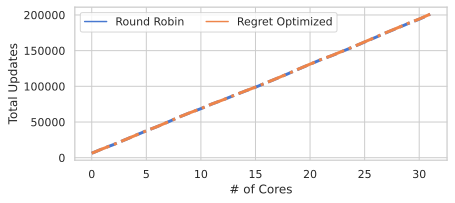

In [256]:
plt.figure(figsize=(6.5, 3))
ax = sns.lineplot(
    data=nfits, x="shard_idx", y="num_forecasts", hue="policy", linewidth=3
)
plt.legend(loc="upper left", ncol=2)
ax.lines[0].set_linestyle("--")
ax.lines[1].set_linestyle("-.")
plt.ylabel("Total Updates")
plt.xlabel("# of Cores")
plt.tight_layout()
plt.savefig("scaling-april-15-10k-keys.pdf", dpi=300)

<AxesSubplot:>

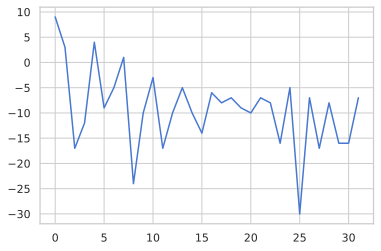

In [257]:
r_ = rr_num_fits.groupby("shard_idx")["num_forecasts"].sum().reset_index()
c_ = ce_num_fits.groupby("shard_idx")["num_forecasts"].sum().reset_index()
(r_["num_forecasts"] - c_["num_forecasts"]).plot()

<AxesSubplot:>

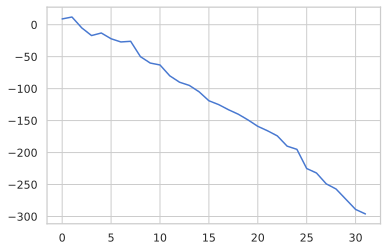

In [258]:
r_ = rr_num_fits.groupby("shard_idx")["num_forecasts"].sum().cumsum().reset_index()
c_ = ce_num_fits.groupby("shard_idx")["num_forecasts"].sum().cumsum().reset_index()
(r_["num_forecasts"] - c_["num_forecasts"]).plot()

{12: 0,
 24: 1,
 8: 2,
 20: 3,
 0: 4,
 18: 5,
 22: 6,
 16: 7,
 4: 8,
 3: 9,
 6: 10,
 5: 11,
 2: 12,
 7: 13,
 1: 14,
 19: 15,
 11: 16,
 31: 17,
 29: 18,
 23: 19,
 25: 20,
 21: 21,
 14: 22,
 30: 23,
 9: 24,
 15: 25,
 10: 26,
 17: 27,
 27: 28,
 13: 29,
 28: 30,
 26: 31}

0        4
1        4
2        4
3        4
4        4
        ..
9995    17
9996    17
9997    17
9998    17
9999    17
Name: shard_idx, Length: 10000, dtype: int64

In [228]:
ce_num_fits[ce_num_fits["shard_idx"] == 0]["key"].sort_values()

66         6
0         32
106       33
69       108
237      261
       ...  
3       9792
244     9882
2       9888
107    10000
23     10004
Name: key, Length: 310, dtype: int64

In [239]:
rr_num_fits[rr_num_fits["key"] == 6]

,key,num_forecasts,shard_idx
3751,6,27,12


In [240]:
rr_num_fits[rr_num_fits["shard_idx"] == 12]["key"].sort_values()

3751        6
3701       32
3802       33
3764      108
3938      261
        ...  
3819     9792
3945     9882
3818     9888
3803    10000
3709    10004
Name: key, Length: 310, dtype: int64

In [62]:
mse_per_key_per_s

,mse,count,key
timestamp,,,
1648838508,9.737886,6.0,24
1648838509,0.000993,1.0,24
1648838510,3.965169,6.0,24
1648838512,0.202032,6.0,24
1648838514,0.166729,6.0,24
...,...,...,...
1648840068,0.667228,11.0,24
1648840069,0.167884,11.0,24
1648840070,0.094301,12.0,24


In [6]:
for key in ["4"]:
    pred_df = (
        pd.DataFrame(
            {
                "timestamp": key_to_timestamps[key],
                "last_seqno": key_to_last_seqnos[key],
            }
        )
        .sort_values("timestamp")
        .set_index("timestamp")
    )
    true_df = (
        pd.DataFrame(
            {
                "timestamp": key_to_source_timestamps[key],
                "avg_cpu": key_to_source_series[key],
                "seq_no": key_to_source_seqno[key],
            }
        )
        .sort_values("timestamp")
        .set_index("timestamp")
    )

    merged = pd.merge_asof(
        left=true_df, right=pred_df, on="timestamp", direction="backward"
    )

    forecast = key_to_last_seqno_to_forecast[key]
    frame = pd.DataFrame(forecast)
    frame = (
        frame.T.reset_index()
        .melt("index")
        .rename(columns={"variable": "seq_delta", "index": "last_seqno"})
    )

In [7]:
m = merged.dropna().reset_index(drop=True)
m.loc[:, "seq_delta"] = (m["seq_no"] - m["last_seqno"]).astype(int)

In [8]:
final = m.merge(frame, how="left", on=["last_seqno", "seq_delta"])

In [22]:
mse_per_key_per_s = final.groupby(final["timestamp"].astype(int)).apply(
    lambda d: ((d["avg_cpu"] - d["value"]) ** 2).mean()
)

In [9]:
final

,timestamp,avg_cpu,seq_no,last_seqno,seq_delta,value
0,1.648839e+09,1.662103,865,863.0,2,2.965487
1,1.648839e+09,1.712143,866,863.0,3,2.324173
2,1.648839e+09,1.673165,867,863.0,4,2.423415
3,1.648839e+09,1.742228,868,863.0,5,2.495467
4,1.648839e+09,1.692552,869,863.0,6,2.368760
...,...,...,...,...,...,...
7768,1.648840e+09,1.779418,8634,6912.0,1722,1.732195
7769,1.648840e+09,4.040145,8635,6912.0,1723,1.738995
7770,1.648840e+09,2.902475,8636,6912.0,1724,2.511317
7771,1.648840e+09,1.806433,8637,6912.0,1725,1.637910


<AxesSubplot:>

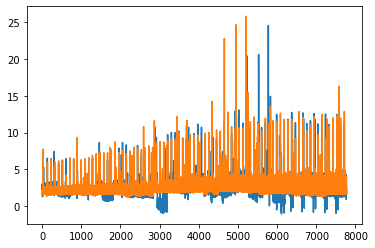

In [10]:
final["value"].plot()
final["avg_cpu"].plot()

<AxesSubplot:>

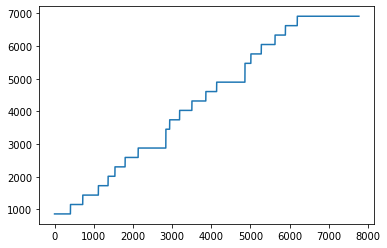

In [11]:
final["last_seqno"].plot()

timestamp
1648838508    0.683256
1648838509    1.469688
1648838510    0.663789
1648838512    0.559614
1648838514    5.497149
                ...   
1648840068    1.088691
1648840069    1.074331
1648840070    0.774803
1648840071    0.764997
1648840072    0.935548
Length: 1458, dtype: float64

In [120]:
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

In [129]:
window_size = 12 * 24 * 3
last_seqno = -window_size
key_error = []
for w in final.rolling(window=window_size):
    if len(w) != window_size:
        continue
    start_seqno = w.loc[:, "seq_no"].iloc[0]
    if start_seqno < last_seqno + window_size:
        continue
    last_seqno = start_seqno
    error = mean_absolute_scaled_error(
        y_true=w["avg_cpu"], y_pred=w["value"], y_train=w["avg_cpu"]
    )
    key_error.append(
        {
            "start_seqno": w.loc[:, "seq_no"].iloc[0],
            "end_seqno": w.loc[:, "seq_no"].iloc[window_size - 1],
            "start_timestamp": w.loc[:, "timestamp"].iloc[0],
            "end_timestamp": w.loc[:, "timestamp"].iloc[window_size - 1],
            "error": error,
        }
    )

error_df = pd.DataFrame(key_error)

In [130]:
error_df

,start_seqno,end_seqno,start_timestamp,end_timestamp,error
0,1337,2200,1.648769e+09,1.648769e+09,3.287409
1,2201,3064,1.648769e+09,1.648769e+09,4.077880
2,3065,3928,1.648769e+09,1.648769e+09,4.294362
3,3929,4792,1.648769e+09,1.648769e+09,4.900465
4,4793,5656,1.648769e+09,1.648769e+09,1.579262
5,5657,6521,1.648769e+09,1.648769e+09,1.379243
6,6521,7384,1.648769e+09,1.648769e+09,2.167958
7,7385,8248,1.648769e+09,1.648769e+09,1.919189


In [122]:
w

,timestamp,avg_cpu,seq_no,last_seqno,seq_delta,value
0,1.648769e+09,2.610784,1337,863.0,474,2.660848
1,1.648769e+09,1.696048,1338,863.0,475,2.974216
2,1.648769e+09,1.641875,1339,863.0,476,2.668436
3,1.648769e+09,1.653233,1340,863.0,477,2.667536
4,1.648769e+09,1.640912,1341,863.0,478,3.162648
...,...,...,...,...,...,...
859,1.648769e+09,1.651560,2196,863.0,1333,3.200259
860,1.648769e+09,1.833575,2197,863.0,1334,3.099616
861,1.648769e+09,1.970052,2198,863.0,1335,3.155905
862,1.648769e+09,1.672129,2199,863.0,1336,3.121561


In [73]:
forecast = key_to_last_seqno_to_forecast["4"]

<AxesSubplot:>

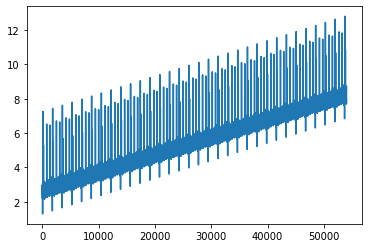

In [84]:
frame[frame["index"] == 863]["value"].plot()

<AxesSubplot:>

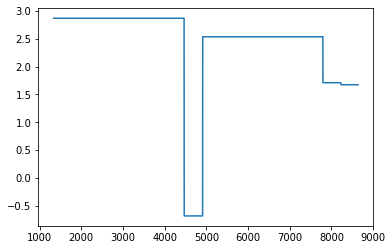

In [43]:
merged.dropna()["forecast"].plot()